## 1. 保存模型并打包整个流程，同时计算AUC并绘制ROC曲线

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

## 2. 加载模型并预测新数据，同时计算AUC并绘制ROC曲线

In [3]:
# 加载保存的Pipeline
pipeline_path = 'MLPClassifier_pipeline.pkl'
loaded_pipeline = joblib.load(pipeline_path)

In [ ]:
# 加载新的数据进行预测（假设已经有一个新的数据集）
new_data = pd.read_excel('d:\\20241111_BC_cfDNA\\00_Backup\\BC_03_EVD_features.xlsx')  # 示例数据集
new_data = new_data.fillna(0)

In [ ]:
# 准备数据
X_new = new_data.iloc[:, 3:2206]  # 提取新数据中的特征
groups_new = new_data['SampleID']  # 组信息
y_true_new = new_data['status'].apply(lambda x: 1 if x == 'malignant' else 0)  # 真实状态

In [6]:
# 使用加载的模型进行预测
y_pred_new = loaded_pipeline.predict(X_new)
y_prob_new = loaded_pipeline.predict_proba(X_new)[:, 1]  # 获取预测为malignant的概率

In [7]:
# 计算ROC曲线并绘制
fpr_new, tpr_new, thresholds_new = roc_curve(y_true_new, y_prob_new)
roc_auc_new = auc(fpr_new, tpr_new)

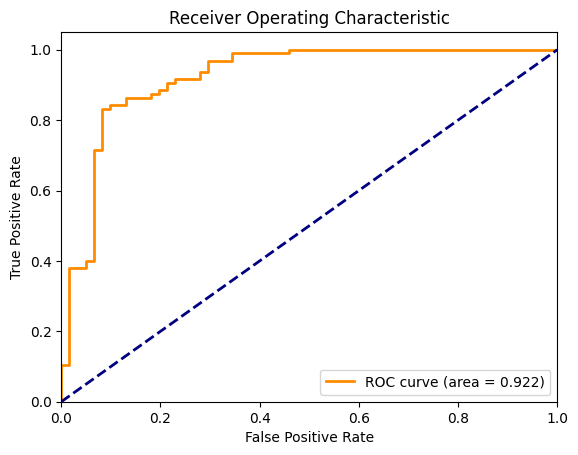

In [8]:
plt.figure()
plt.plot(fpr_new, tpr_new, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_new)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
# 创建包含预测结果和组信息的数据框
results_new_df = pd.DataFrame({
    'Group': groups_new,
    'True Status': y_true_new,
    'Predicted Status': y_pred_new,
    'Malignant Probability': y_prob_new
})

In [10]:
# 输出到Excel文件
output_new_path = '03_prediction_results.xlsx'
results_new_df.to_excel(output_new_path, index=False)

In [11]:
# 打印输出文件路径和AUC值
print(f"Results for new data saved to: {output_new_path}")
print(f"AUC for new data: {roc_auc_new:.3f}")

Results for new data saved to: 03_prediction_results.xlsx
AUC for new data: 0.922


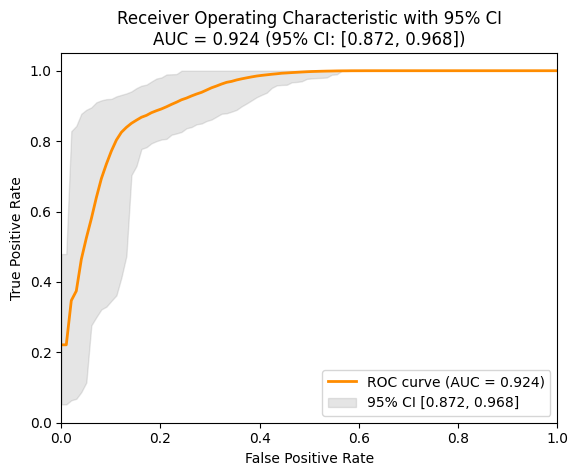

AUC: 0.924
95% CI for AUC: [0.872, 0.968]
Sensitivity: 0.938 (95% CI: [0.891, 0.979])
Specificity: 0.704 (95% CI: [0.576, 0.815])
PPV: 0.832 (95% CI: [0.755, 0.905])
NPV: 0.878 (95% CI: [0.787, 0.957])


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import resample

# 假设 y_true_new 是真实的标签，y_prob_new 是预测的概率
n_bootstraps = 1000
bootstrapped_aucs = []
mean_fpr = np.linspace(0, 1, 100)  # 生成0到1的100个等间隔的点
tprs = []  # 保存每次bootstrap的tpr

# 固定随机种子以确保可复现
rng = np.random.RandomState(42)

# 进行Bootstrap采样，计算AUC、ROC曲线以及敏感性、特异性、PPV、NPV
sensitivities = []
specificities = []
ppvs = []
npvs = []

# 定义一个阈值来将概率转化为二元分类结果，通常是0.5
threshold = 0.5

for i in range(n_bootstraps):
    # 有放回地进行采样
    indices = rng.randint(0, len(y_true_new), len(y_true_new))
    if len(np.unique(y_true_new[indices])) < 2:
        # 如果采样后的数据只有一个类，跳过本次计算
        continue
    
    y_true_bootstrap = y_true_new[indices]
    y_prob_bootstrap = y_prob_new[indices]
    
    # 计算ROC曲线
    fpr, tpr, _ = roc_curve(y_true_bootstrap, y_prob_bootstrap)
    
    # 使用插值将TPR插值到mean_fpr对应的FPR值上
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interp)
    
    # 计算AUC
    auc = roc_auc_score(y_true_bootstrap, y_prob_bootstrap)
    bootstrapped_aucs.append(auc)
    
    # 使用阈值0.5生成预测标签
    y_pred_bootstrap = (y_prob_bootstrap >= threshold).astype(int)
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_true_bootstrap, y_pred_bootstrap).ravel()
    
    # 计算Sensitivity, Specificity, PPV, NPV
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    ppvs.append(ppv)
    npvs.append(npv)

# 计算95%置信区间
sorted_auc_scores = np.sort(bootstrapped_aucs)
lower_bound_auc = np.percentile(sorted_auc_scores, 2.5)
upper_bound_auc = np.percentile(sorted_auc_scores, 97.5)

# 计算Sensitivity, Specificity, PPV, NPV的均值和置信区间
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_ppv = np.mean(ppvs)
mean_npv = np.mean(npvs)

ci_sensitivity = (np.percentile(sensitivities, 2.5), np.percentile(sensitivities, 97.5))
ci_specificity = (np.percentile(specificities, 2.5), np.percentile(specificities, 97.5))
ci_ppv = (np.percentile(ppvs, 2.5), np.percentile(ppvs, 97.5))
ci_npv = (np.percentile(npvs, 2.5), np.percentile(npvs, 97.5))

# 计算mean_tpr和95%置信区间
tprs = np.array(tprs)
mean_tpr = tprs.mean(axis=0)
std_tpr = tprs.std(axis=0)
tpr_lower = np.percentile(tprs, 2.5, axis=0)
tpr_upper = np.percentile(tprs, 97.5, axis=0)

# 绘制ROC曲线和95%置信区间
plt.figure()

# 主ROC曲线
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {np.mean(bootstrapped_aucs):.3f})')

# 绘制95%置信区间带
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='gray', alpha=0.2, 
                 label=f'95% CI [{lower_bound_auc:.3f}, {upper_bound_auc:.3f}]')

# 图的基本设置
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic with 95% CI\nAUC = {np.mean(bootstrapped_aucs):.3f} (95% CI: [{lower_bound_auc:.3f}, {upper_bound_auc:.3f}])')

# 添加图例
plt.legend(loc="lower right")

# 显示图像
plt.show()

# 打印AUC及其95%置信区间
print(f"AUC: {np.mean(bootstrapped_aucs):.3f}")
print(f"95% CI for AUC: [{lower_bound_auc:.3f}, {upper_bound_auc:.3f}]")

# 打印Sensitivity, Specificity, PPV, NPV及其95%置信区间
print(f"Sensitivity: {mean_sensitivity:.3f} (95% CI: [{ci_sensitivity[0]:.3f}, {ci_sensitivity[1]:.3f}])")
print(f"Specificity: {mean_specificity:.3f} (95% CI: [{ci_specificity[0]:.3f}, {ci_specificity[1]:.3f}])")
print(f"PPV: {mean_ppv:.3f} (95% CI: [{ci_ppv[0]:.3f}, {ci_ppv[1]:.3f}])")
print(f"NPV: {mean_npv:.3f} (95% CI: [{ci_npv[0]:.3f}, {ci_npv[1]:.3f}])")